Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [3]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [4]:
CONSTRAINTS

array([[ 30, 330],
       [212,  32],
       [ 32, 110]])

## TEST PROBLEMS

In [5]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [6]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [7]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [8]:
class BaseSolver:
    """
    Base class for a Multiple Multidimensional Knapsack Problem (MMKP) solver.
    
    This class holds the problem definition (data) and utility methods
    to evaluate, and modify solutions.
    
    A "solution" is a NumPy array (shape: [NUM_ITEMS,]) where solution[i] = k:
     - k = -1  => item i is not assigned to any knapsack
     - k = 0   => item i is assigned to knapsack 0
     - k ...   => item i is assigned to knapsack k
    """
    
    def __init__(self, 
                 values:np.ndarray, 
                 weights:np.ndarray, 
                 constraints:np.ndarray, 
                 num_knapsacks:int, 
                 seed:int=42):
        """
        Initializes the solver with the problem data.
        """

        self.values = values             # (NUM_ITEMS,)
        self.weights = weights           # (NUM_ITEMS, NUM_DIMENSIONS)
        self.constraints = constraints   # (NUM_KNAPSACKS, NUM_DIMENSIONS)
        
        self.num_items = len(values)
        self.num_knapsacks = num_knapsacks
        self.num_dims = weights.shape[1]
        
        self.possible_assignments = list(range(-1, self.num_knapsacks))
        self.fitness_history = []
        self.rng = np.random.default_rng(seed)

    def _is_feasible(self, solution:np.ndarray) -> bool:
        """
        Checks if a given solution violates any constraints.
        Returns True if the solution is feasible, False otherwise.
        """
        try:
            usage = np.zeros((self.num_knapsacks, self.num_dims))

            for i in range(self.num_items):
                k = solution[i]
                
                if k != -1:
                    usage[k] += self.weights[i]

            if np.any(usage > self.constraints):
                return False
            
            return True
            
        except IndexError:
            # Safety catch if solution contains an invalid knapsack index
            return False

    def _fitness(self, solution:np.ndarray) -> float:
        """
        Calculates the fitness (total value) of a solution.
        A solution that is not feasible gets a fitness of 0.
        """
        if not self._is_feasible(solution):
            return 0  
        
        total_value = 0.0
        
        for i in range(self.num_items):
            if solution[i] != -1: 
                total_value += self.values[i]
                
        return total_value

    def _tweak(self, solution:np.ndarray) -> np.ndarray:
        """
        Applies a single, random modification to a solution.
        """
        neighbor = solution.copy()
        
        # Pick a random item to change
        item_to_tweak = self.rng.integers(0, self.num_items)
        current_assignment = solution[item_to_tweak]
        
        # Pick a new, *different* assignment for that item
        other_assignments = [a for a in self.possible_assignments if a != current_assignment]
        new_assignment = self.rng.choice(other_assignments)
        
        # Apply the change
        neighbor[item_to_tweak] = new_assignment
        return neighbor

    def _get_initial_solution(self):
        """
        Generates the empty initial solution (all -1s)
        for a guaranteed feasible starting point.
        """
        # Create an integer array, with length num_items,
        # filled with the value -1.
        return np.full(shape=self.num_items, fill_value=-1, dtype=int)

    def solve(self, start_solution:np.ndarray=None):
        """
        Abstract 'solve' method.
        This must be implemented by specific solver subclasses
        (e.g., HillClimber, SimulatedAnnealing).
        """
        raise NotImplementedError(
            "The 'solve' method must be implemented by a subclass."
        )

In [9]:
class HillClimber(BaseSolver):
    """
    Implements a Stochastic Hill Climbing algorithm.
    """
    
    def __init__(self, 
                 values:np.ndarray, 
                 weights:np.ndarray, 
                 constraints:np.ndarray, 
                 num_knapsacks:int, 
                 seed:int=42):
        """
        Initializes the HillClimber solver.
        Calls the parent constructor to set up the problem data.
        """
        super().__init__(values, weights, constraints, num_knapsacks, seed)
        
    def solve(self, 
              start_solution:np.ndarray=None, 
              max_iterations:int=1000, 
              verbose=True) -> tuple[np.ndarray, np.ndarray]:
        """
        Executes the Stochastic Hill Climbing algorithm.

        Args:
            start_solution (np.array, optional): An initial solution to start from.
                If None, a random solution is generated.
            max_iterations (int, optional): The total number of attempts (tweaks)
                to make.
            verbose (bool, optional): If True, prints progress updates.
        
        Returns:
            tuple: (best_solution, best_fitness)
                   The best solution found after max_iterations attempts.
        """
        
        # Initialization
        self.fitness_history = []

        if start_solution is None:
            self.current_solution = self._get_initial_solution()
        else:
            self.current_solution = start_solution.copy()
            
        self.current_fitness = self._fitness(self.current_solution)
        self.fitness_history.append(self.current_fitness)
        
        if verbose:
            print(f"Stochastic HC: Initial fitness = {self.current_fitness}")
        
        # Main Loop
        for i in range(max_iterations):
            
            neighbor = self._tweak(self.current_solution)
            neighbor_fitness = self._fitness(neighbor)
            
            if neighbor_fitness > self.current_fitness:
                # Move to the better neighbor
                self.current_solution = neighbor
                self.current_fitness = neighbor_fitness
                
                if verbose:
                    print(f"  -> Step {i+1}: Improvement! New fitness = {self.current_fitness}")
            
            elif neighbor_fitness == self.current_fitness:
                # Accept equal fitness neighbors (can help escape plateaus)
                self.current_solution = neighbor
            
            self.fitness_history.append(self.current_fitness)

        # Return Result
        if verbose:
            print(f"Stochastic HC finished after {max_iterations} iterations.")
            print(f"Final fitness: {self.current_fitness}")
            
        return self.current_solution, self.current_fitness

In [10]:
class SimulatedAnnealing(BaseSolver):
    """
    Implements the Simulated Annealing (SA) algorithm.
    
    This solver inherits from BaseSolver and uses a probabilistic
    acceptance criterion to decide whether to move to a neighbor,
    allowing it to escape local optima by occasionally accepting
    worse solutions.
    """
    
    def __init__(self, 
                 values:np.ndarray, 
                 weights:np.ndarray, 
                 constraints:np.ndarray, 
                 num_knapsacks:int, 
                 seed:int=42):
        """
        Initializes the SimulatedAnnealing solver.
        Calls the parent constructor to set up the problem data.
        """
        super().__init__(values, weights, constraints, num_knapsacks, seed)
        
    def solve(self, 
              scheduler_fn:callable,
              start_solution:np.ndarray=None, 
              max_iterations:int=1000,
              verbose=True) -> tuple[np.ndarray, float]:
        """
        Executes the Simulated Annealing algorithm using a provided
        scheduler function.
        
        Args:
            scheduler_fn (callable): A function that takes one argument
                (progress, float from 0.0 to 1.0) and returns
                the current temperature.
            start_solution (np.array, optional): Initial solution.
            max_iterations (int, optional): Total number of tweaks.
            verbose (bool, optional): If True, prints progress.
        
        Returns:
            tuple: (best_solution, best_fitness)
        """
        
        # Initialization
        self.fitness_history = []

        if start_solution is None:
            self.current_solution = self._get_initial_solution()
        else:
            self.current_solution = start_solution.copy()
            
        self.current_fitness = self._fitness(self.current_solution)
        self.best_solution = self.current_solution.copy()
        self.best_fitness = self.current_fitness
        self.fitness_history.append(self.best_fitness)
        
        if verbose:
            print(f"SA: Initial fitness = {self.current_fitness}")
        
        # Main Loop
        for i in range(max_iterations):
            
            progress = i / max_iterations
            current_temp = scheduler_fn(progress)
            
            # Check for zero temperature
            if current_temp < 1e-9:
                if verbose and i < max_iterations -1:
                    print(f"Temperature reached zero at iter {i}. Stopping.")
                break

            neighbor = self._tweak(self.current_solution)
            neighbor_fitness = self._fitness(neighbor)
            
            delta_f = neighbor_fitness - self.current_fitness
            
            if delta_f > 0:
                # Move to the better neighbor
                self.current_solution = neighbor
                self.current_fitness = neighbor_fitness

                if self.current_fitness > self.best_fitness:

                    self.best_solution = self.current_solution.copy()
                    self.best_fitness = self.current_fitness

                    if verbose:
                        print(f"  -> Step {i+1}: Improvement! New fitness = {self.current_fitness}, T={current_temp:.2f}")
            else:
                acceptance_prob = np.exp(delta_f / current_temp)

                if self.rng.random() < acceptance_prob:
                    # Move to the worst neighbor
                    self.current_solution = neighbor
                    self.current_fitness = neighbor_fitness
            
            self.fitness_history.append(self.best_fitness)
            
        # Return Result
        if verbose:
            print(f"SA finished after {i+1} iterations.")
            print(f"Final best fitness found: {self.best_fitness}")
            
        return self.best_solution, self.best_fitness

In [11]:
def linear_schedule(T_max:float, T_min:float) -> callable:
    """
    Returns a scheduler function that calculates a linear
    temperature decay based on progress (0.0 -> 1.0).

    Args:
        T_max (float): The starting (maximum) temperature.
        T_min (float): The ending (minimum) temperature.

    Returns:
        callable: A function that takes 'progress' (float 0.0-1.0)
                  and returns the current temperature.
    """

    delta_T = T_max - T_min
    
    def scheduler(progress: float) -> float:
        """
        Calculates the temperature at a given progress point.
        
        Args:
            progress (float): The fraction of total iterations completed (0.0 to 1.0).
        
        Returns:
            float: The calculated temperature for this progress point.
        """
        
        current_T = T_max - (progress * delta_T)
        return max(current_T, T_min)
        
    return scheduler


def stair_schedule(T_max:float, T_min:float, num_steps:int=10) -> callable:
    """
    Returns a scheduler function that calculates a "staircase"
    temperature decay. The temperature is held constant for a
    period before dropping to the next level.

    Args:
        T_max (float): The starting (maximum) temperature.
        T_min (float): The ending (minimum) temperature.
        num_steps (int): The number of discrete temperature "steps"
                         to take (must be at least 1).

    Returns:
        callable: A function that takes 'progress' (float 0.0-1.0)
                  and returns the current temperature.
    """
    if num_steps < 1:
        num_steps = 1
        
    delta_T = T_max - T_min
    
    if num_steps > 1:
        temp_drop_per_step = delta_T / (num_steps - 1)
    else:
        temp_drop_per_step = 0 # T will remain T_max
    
    def scheduler(progress: float) -> float:
        """
        Calculates the temperature for the current "stair".
        
        Args:
            progress (float): The fraction of total iterations completed (0.0 to 1.0).
        
        Returns:
            float: The calculated temperature for this step.
        """
        # Handle the progress=1.0 edge case
        if progress >= 1.0:
            return T_min
            
        current_step_index = np.floor(progress * num_steps)
        current_T = T_max - (current_step_index * temp_drop_per_step)
        
        return max(current_T, T_min)
        
    return scheduler

In [12]:
def print_solution_summary(solution:np.ndarray, 
                           fitness:float, 
                           solver:BaseSolver, 
                           verbose:bool=True) -> None:
    """
    Prints a well-formatted summary of the final solution.
    Uses an efficient O(N*D) pass to calculate resource usage.

    Args:
        solution (np.array): The final solution vector.
        fitness (float): The final fitness value.
        solver (BaseSolver): The solver instance used, to access
                             the problem's data (weights, constraints).
        verbose (bool): If True, prints detailed knapsack usage.
    """
    
    print("--- Optimization Result ---")
    print(f"Final Fitness: {fitness:.2f}")
    
    total_items_assigned = np.sum(solution != -1)
    print(f"Items Assigned: {total_items_assigned} \ {solver.num_items}")

    if verbose:
        print("-" * 27)
        usage = np.zeros((solver.num_knapsacks, solver.num_dims))
        items_per_knapsack = np.zeros(solver.num_knapsacks, dtype=int)

        for i in range(solver.num_items):
            k = solution[i]
            
            if k != -1:
                usage[k] += solver.weights[i]
                items_per_knapsack[k] += 1

        for k in range(solver.num_knapsacks):
            
            num_items_in_k = items_per_knapsack[k]
            
            if num_items_in_k == 0:
                print(f"Knapsack {k}: EMPTY")
                continue
                
            print(f"Knapsack {k} (Items: {num_items_in_k})")
            
    print("--- End of Summary --------\n") 

In [13]:
def plot_fitness_history(history_log:list, title:str="Fitness vs. Iterations") -> None:
    """
    Plots the fitness history over time (iterations).

    Args:
        history_log (list): The list of fitness values returned from solve().
        title (str): The title for the plot.
    """
    
    plt.figure(figsize=(12, 6))
    plt.plot(history_log)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [14]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

--- Optimization Result ---
Final Fitness: 1065.00
Items Assigned: 20 \ 20
---------------------------
Knapsack 0 (Items: 10)
Knapsack 1 (Items: 6)
Knapsack 2 (Items: 4)
--- End of Summary --------



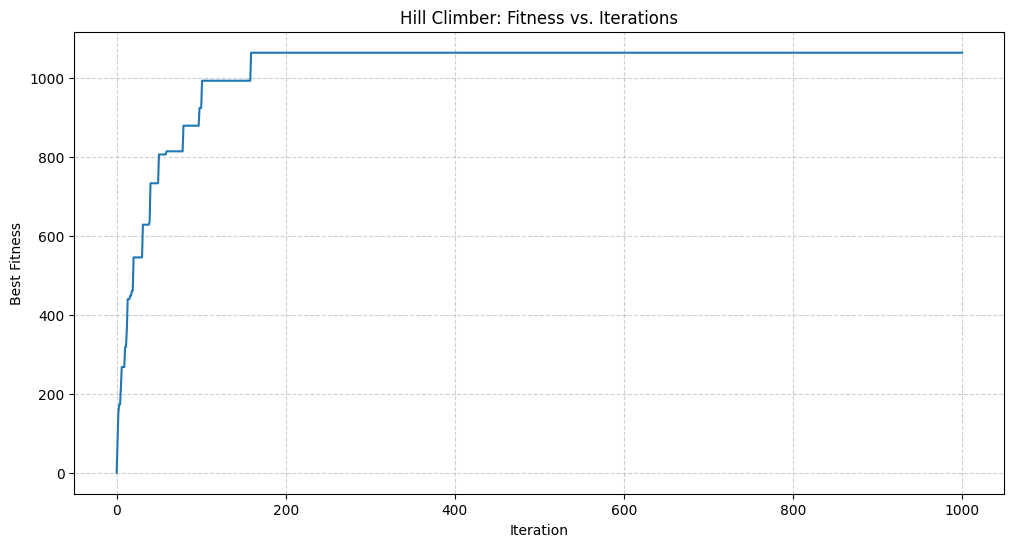

In [15]:
hc_solver = HillClimber(VALUES, WEIGHTS, CONSTRAINTS, NUM_KNAPSACKS, seed=42)
best_solution_hc, best_fitness_hc = hc_solver.solve(max_iterations=1000, verbose=False)

print_solution_summary(best_solution_hc, best_fitness_hc, hc_solver)
plot_fitness_history(hc_solver.fitness_history, title="Hill Climber: Fitness vs. Iterations")

--- Optimization Result ---
Final Fitness: 1065.00
Items Assigned: 20 \ 20
---------------------------
Knapsack 0 (Items: 10)
Knapsack 1 (Items: 7)
Knapsack 2 (Items: 3)
--- End of Summary --------



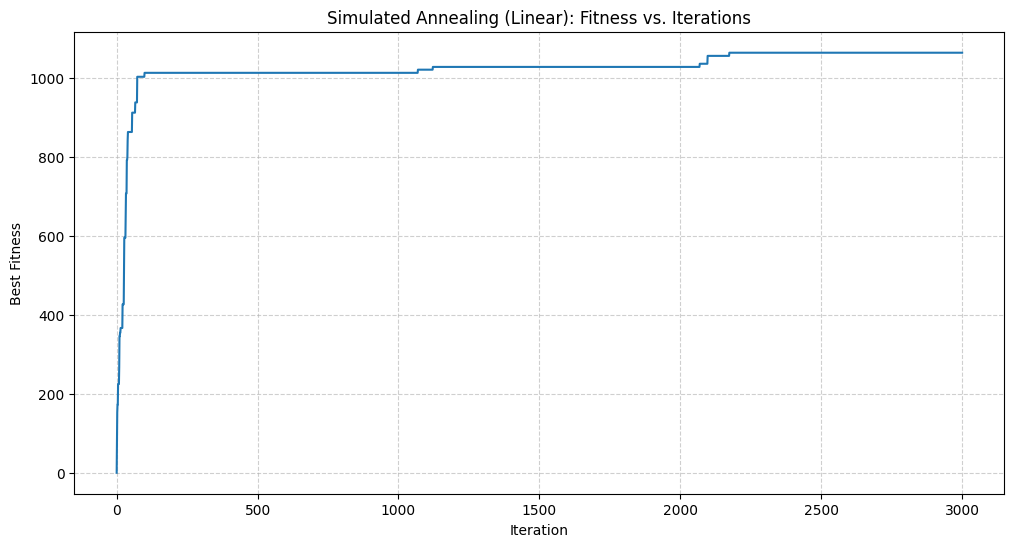

--- Optimization Result ---
Final Fitness: 1065.00
Items Assigned: 20 \ 20
---------------------------
Knapsack 0 (Items: 11)
Knapsack 1 (Items: 5)
Knapsack 2 (Items: 4)
--- End of Summary --------



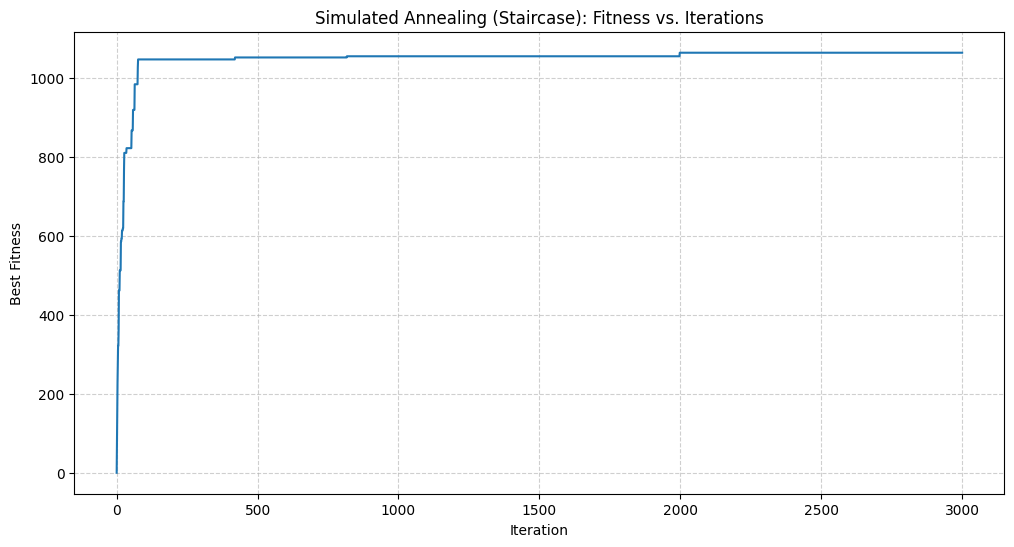

In [16]:
sa_solver = SimulatedAnnealing(VALUES, WEIGHTS, CONSTRAINTS, NUM_KNAPSACKS, seed=42)
best_solution_sa_lin, best_fitness_sa_lin = sa_solver.solve(
    scheduler_fn=linear_schedule(T_max=100.0, T_min=1.0),
    max_iterations=3000,
    verbose=False
)
print_solution_summary(best_solution_sa_lin, best_fitness_sa_lin, sa_solver)
plot_fitness_history(sa_solver.fitness_history, title="Simulated Annealing (Linear): Fitness vs. Iterations")

best_solution_sa_st, best_fitness_sa_st = sa_solver.solve(
    scheduler_fn=stair_schedule(T_max=100.0, T_min=1.0, num_steps=20),
    max_iterations=3000,
    verbose=False
)
print_solution_summary(best_solution_sa_st, best_fitness_sa_st, sa_solver)
plot_fitness_history(sa_solver.fitness_history, title="Simulated Annealing (Staircase): Fitness vs. Iterations")

In [17]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

--- Optimization Result ---
Final Fitness: 38143.00
Items Assigned: 77 \ 100
---------------------------
Knapsack 0 (Items: 7)
Knapsack 1 (Items: 7)
Knapsack 2 (Items: 6)
Knapsack 3 (Items: 9)
Knapsack 4 (Items: 11)
Knapsack 5 (Items: 8)
Knapsack 6 (Items: 7)
Knapsack 7 (Items: 4)
Knapsack 8 (Items: 8)
Knapsack 9 (Items: 10)
--- End of Summary --------



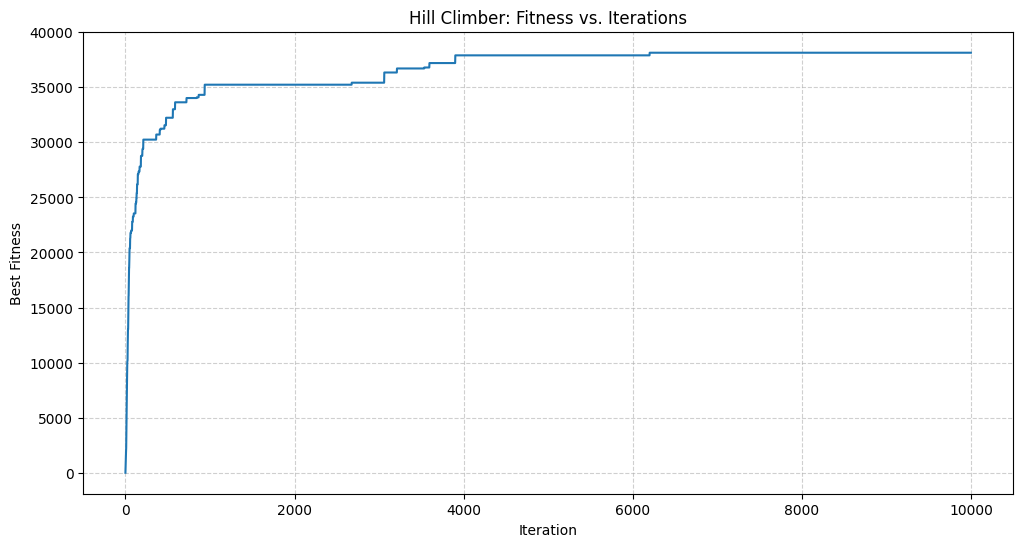

In [18]:
hc_solver = HillClimber(VALUES, WEIGHTS, CONSTRAINTS, NUM_KNAPSACKS, seed=42)
best_solution_hc, best_fitness_hc = hc_solver.solve(max_iterations=10000, verbose=False)
print_solution_summary(best_solution_hc, best_fitness_hc, hc_solver)
plot_fitness_history(hc_solver.fitness_history, title="Hill Climber: Fitness vs. Iterations")

--- Optimization Result ---
Final Fitness: 43455.00
Items Assigned: 79 \ 100
--- End of Summary --------



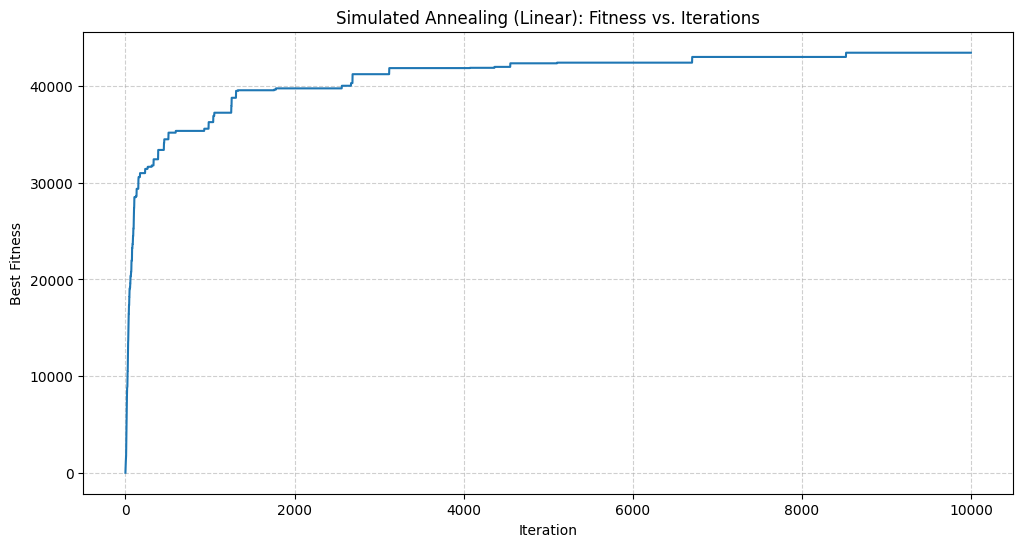

--- Optimization Result ---
Final Fitness: 43478.00
Items Assigned: 80 \ 100
--- End of Summary --------



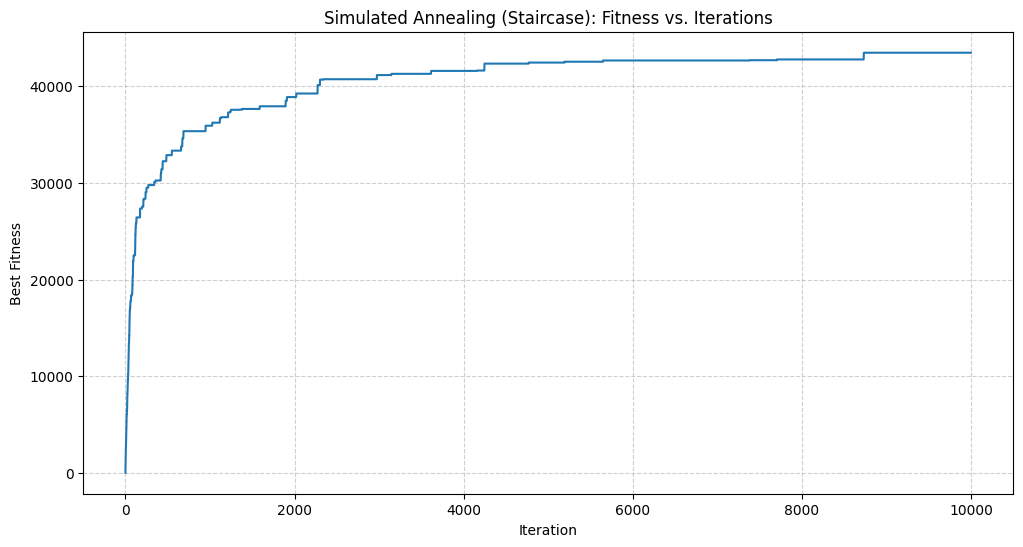

In [19]:
sa_solver = SimulatedAnnealing(VALUES, WEIGHTS, CONSTRAINTS, NUM_KNAPSACKS, seed=42)
best_solution_sa_lin, best_fitness_sa_lin = sa_solver.solve(
    scheduler_fn=linear_schedule(T_max=100.0, T_min=1.0),
    max_iterations=10000,
    verbose=False
)
print_solution_summary(best_solution_sa_lin, best_fitness_sa_lin, sa_solver, verbose=False)
plot_fitness_history(sa_solver.fitness_history, title="Simulated Annealing (Linear): Fitness vs. Iterations")

best_solution_sa_st, best_fitness_sa_st = sa_solver.solve(
    scheduler_fn=stair_schedule(T_max=100.0, T_min=1.0, num_steps=20),
    max_iterations=10000,
    verbose=False
)
print_solution_summary(best_solution_sa_st, best_fitness_sa_st, sa_solver, verbose=False)
plot_fitness_history(sa_solver.fitness_history, title="Simulated Annealing (Staircase): Fitness vs. Iterations")

In [20]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

--- Optimization Result ---
Final Fitness: 1157243.00
Items Assigned: 2324 \ 5000
--- End of Summary --------



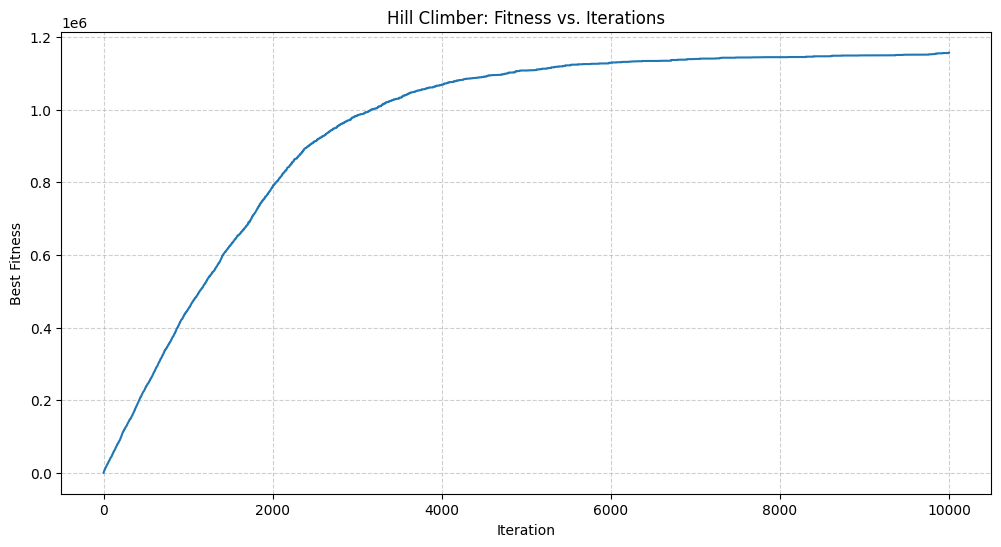

In [21]:
hc_solver = HillClimber(VALUES, WEIGHTS, CONSTRAINTS, NUM_KNAPSACKS, seed=42)
best_solution_hc, best_fitness_hc = hc_solver.solve(max_iterations=10000, verbose=False)
print_solution_summary(best_solution_hc, best_fitness_hc, hc_solver, verbose=False)
plot_fitness_history(hc_solver.fitness_history, title="Hill Climber: Fitness vs. Iterations")

--- Optimization Result ---
Final Fitness: 1166580.00
Items Assigned: 2324 \ 5000
--- End of Summary --------



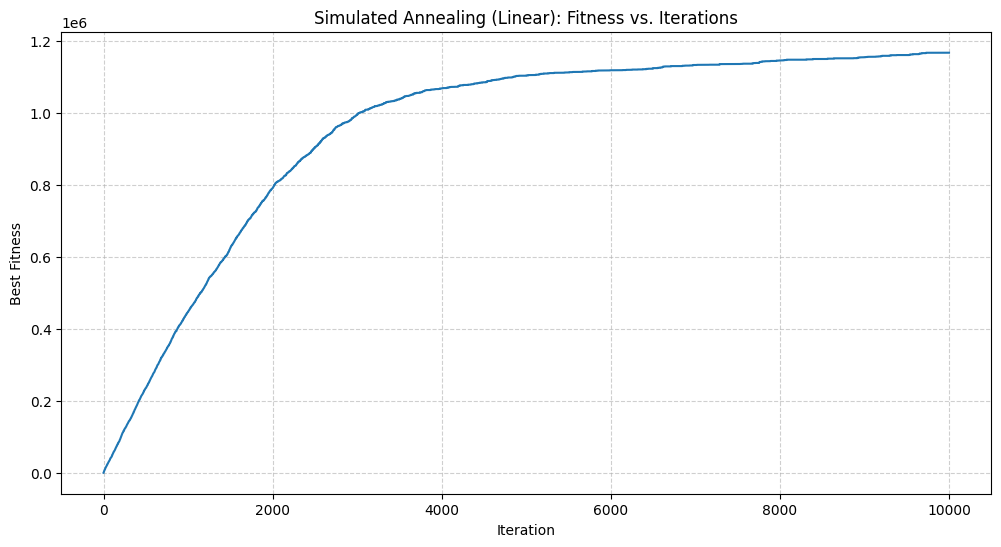

--- Optimization Result ---
Final Fitness: 1147597.00
Items Assigned: 2327 \ 5000
--- End of Summary --------



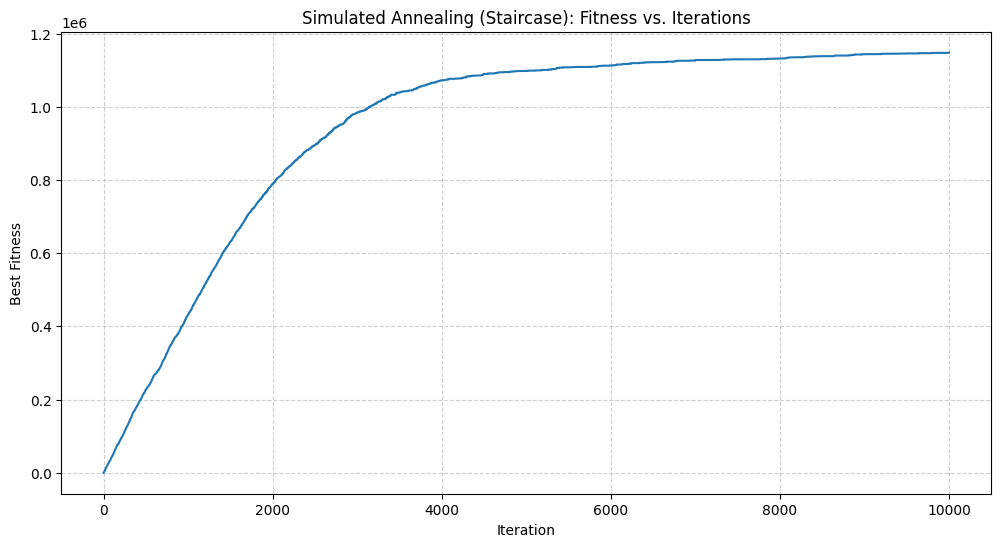

In [22]:
sa_solver = SimulatedAnnealing(VALUES, WEIGHTS, CONSTRAINTS, NUM_KNAPSACKS, seed=42)
best_solution_sa_lin, best_fitness_sa_lin = sa_solver.solve(
    scheduler_fn=linear_schedule(T_max=100.0, T_min=1.0),
    max_iterations=10000,
    verbose=False
)
print_solution_summary(best_solution_sa_lin, best_fitness_sa_lin, sa_solver, verbose=False)
plot_fitness_history(sa_solver.fitness_history, title="Simulated Annealing (Linear): Fitness vs. Iterations")

best_solution_sa_st, best_fitness_sa_st = sa_solver.solve(
    scheduler_fn=stair_schedule(T_max=100.0, T_min=1.0, num_steps=20),
    max_iterations=10000,
    verbose=False
)
print_solution_summary(best_solution_sa_st, best_fitness_sa_st, sa_solver, verbose=False)
plot_fitness_history(sa_solver.fitness_history, title="Simulated Annealing (Staircase): Fitness vs. Iterations")